# Setup

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [ ]:
train = pd.read_csv('./drive/My Drive/Data-X: GGWP Toxic Behavior Public Data/data/train[1].csv')

In [ ]:
train.loc[train['obscene'] == 1, :].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.shape

(159571, 8)

# EDA

# Class Inbalances

In [ ]:
clean_comments = train.iloc[:, 2:].sum(axis=1) == 0

In [ ]:
clean_comments

0         True
1         True
2         True
3         True
4         True
          ... 
159566    True
159567    True
159568    True
159569    True
159570    True
Length: 159571, dtype: bool

In [ ]:
print(f"Clean comments make up {round(clean_comments.sum() / len(train)* 100, 2)} % of the Training Data")

Clean comments make up 89.83 % of the Training Data


In [ ]:
clean_series = pd.Series(clean_comments.sum(), index=['clean'])

In [ ]:
tags = train.iloc[:, 2:].sum()

In [ ]:
tags = tags.append(clean_series)

In [ ]:
tags = tags.sort_values()

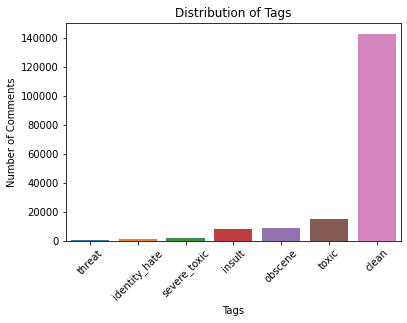

In [ ]:
fig, ax = plt.subplots()

ax = sns.barplot(x=tags.index, y=tags)
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='Tags', ylabel='Number of Comments', title='Distribution of Tags')
plt.show()

# LSTM Baseline Model

## Basic Preprocessing

In [ ]:
x_train = train.loc[:, 'comment_text']
y_train = train.loc[:, 'toxic':'identity_hate'].values

In [ ]:
max_features = 20000
# Convert Words into Index using Tokenizer. Basically, every word is an index number
tokenizer = Tokenizer(num_words=max_features) 
tokenizer.fit_on_texts(list(x_train))
x_train = tokenizer.texts_to_sequences(x_train)

## Choose best length of each vector

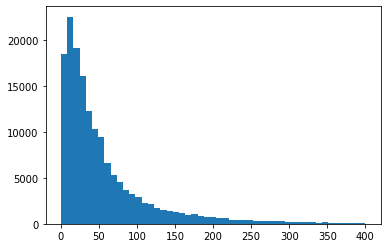

In [ ]:
plt.hist([len(comment) for comment in x_train], bins=np.linspace(0, 400, 50))
plt.show()

Seems like choosing 50 is a reasonable amount


In [ ]:
maxlen = 50
# Makes the vector lengths the same regardless of how many words in comments
x_train = pad_sequences(x_train, maxlen=maxlen) 

## Setting up the Model Architecture

Hyperparameters for Architecture

In [ ]:
embed_size = 128

1. Input Layer / Tensor

In [ ]:
inp = Input(shape=(maxlen,))

2. Embedding Layer


In [ ]:
x = Embedding(max_features, embed_size)(inp)

3. LSTM Layer

In [ ]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

4. Global Max Pooling

In [ ]:
x = GlobalMaxPool1D()(x) # Used to convert the 3D tensor into a 2D one

5. Dense

In [ ]:
x = Dense(50, activation='relu')(x)

6. Dropout

In [ ]:
x = Dropout(0.1)(x)

7. Dense

In [ ]:
x = Dense(6, activation='sigmoid')(x)

## Train Model

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Configurations

In [ ]:
batch_size = 32
epochs = 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 131s 29ms/step - loss: 0.0692 - accuracy: 0.9578 - val_loss: 0.0538 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 126s 28ms/step - loss: 0.0473 - accuracy: 0.9778 - val_loss: 0.0512 - val_accuracy: 0.9939


In [ ]:
x_predict = model.predict(x_train, batch_size=1024, verbose=1)

156/156 [==============================] - 1s 9ms/step


In [ ]:
x_predict[:5, ]

array([[3.9726045e-04, 9.4846023e-08, 4.3118493e-05, 9.1692741e-08,
        1.9636509e-05, 1.8445335e-06],
       [7.4973179e-04, 2.2316325e-07, 6.0215381e-05, 4.9943515e-07,
        3.8521663e-05, 4.5325251e-06],
       [2.8589459e-03, 5.9533681e-07, 1.9251199e-04, 1.2229859e-06,
        1.4412828e-04, 1.2863552e-05],
       [1.3188601e-03, 8.5421215e-07, 2.2808702e-04, 4.9270272e-07,
        8.2268394e-05, 1.0249222e-05],
       [8.8784546e-02, 4.9310416e-05, 4.2933542e-03, 1.4263409e-04,
        7.9465006e-03, 5.5996305e-04]], dtype=float32)

# Get Validation Score

In [ ]:
val_data = pd.read_csv('./drive/My Drive/Data-X: GGWP Toxic Behavior Public Data/data/combined.csv')

In [ ]:
x_val = val_data.loc[:, 'text']
y_val = val_data.loc[:, 'toxic':'indentity_hate'].values

In [ ]:
# Vectorize
x_val = tokenizer.texts_to_sequences(x_val)

In [ ]:
# Pad
x_val = pad_sequences(x_val, maxlen=maxlen) # Makes the vector lengths the same regardless of how many words in comments

In [ ]:
y_pred_val = model.predict(x_val, batch_size=1024, verbose=1)

3/3 [==============================] - 0s 8ms/step


In [ ]:
x_val_score = roc_auc_score(y_val, y_pred_val)

In [ ]:
x_val_score

0.867334293460814

## Add LSTM Results to Model Results CSV

In [ ]:
#model_results = pd.read_csv('./drive/My Drive/Data-X: GGWP Toxic Behavior Public Data/models/model_results.csv', index_col='Unnamed: 0')

In [ ]:
#model_results = pd.concat([model_results, pd.DataFrame({'Model': ['LSTM'], 'val_auc_score': [x_val_score]})])

In [ ]:
#model_results.to_csv('./drive/My Drive/Data-X: GGWP Toxic Behavior Public Data/models/model_results.csv')